In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from collections import Counter
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


# Data observation 

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
sample_submit = pd.read_csv("/kaggle/input/playground-series-s6e2/sample_submission.csv")

In [3]:
sample_submit

,id,Heart Disease
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0
...,...,...
269995,899995,0
269996,899996,0
269997,899997,0
269998,899998,0


In [4]:
train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [5]:
sample_submit["Heart Disease"].value_counts()

Heart Disease
0    270000
Name: count, dtype: int64

In [6]:
CAT_COLUMNS = [
    "Chest pain type",
    "EKG results",
    "Slope of ST",
    "Number of vessels fluro","Thallium", 
    "Sex",
    "FBS over 120",
    "Exercise angina"
]

NUM_COLUMNS = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression"
]

In [7]:
train.drop("id", axis=1, inplace=True)

In [8]:
le = LabelEncoder()
train_with_num_label = train.copy()
train_with_num_label["Heart Disease"] = le.fit_transform(train_with_num_label["Heart Disease"])

<Axes: >

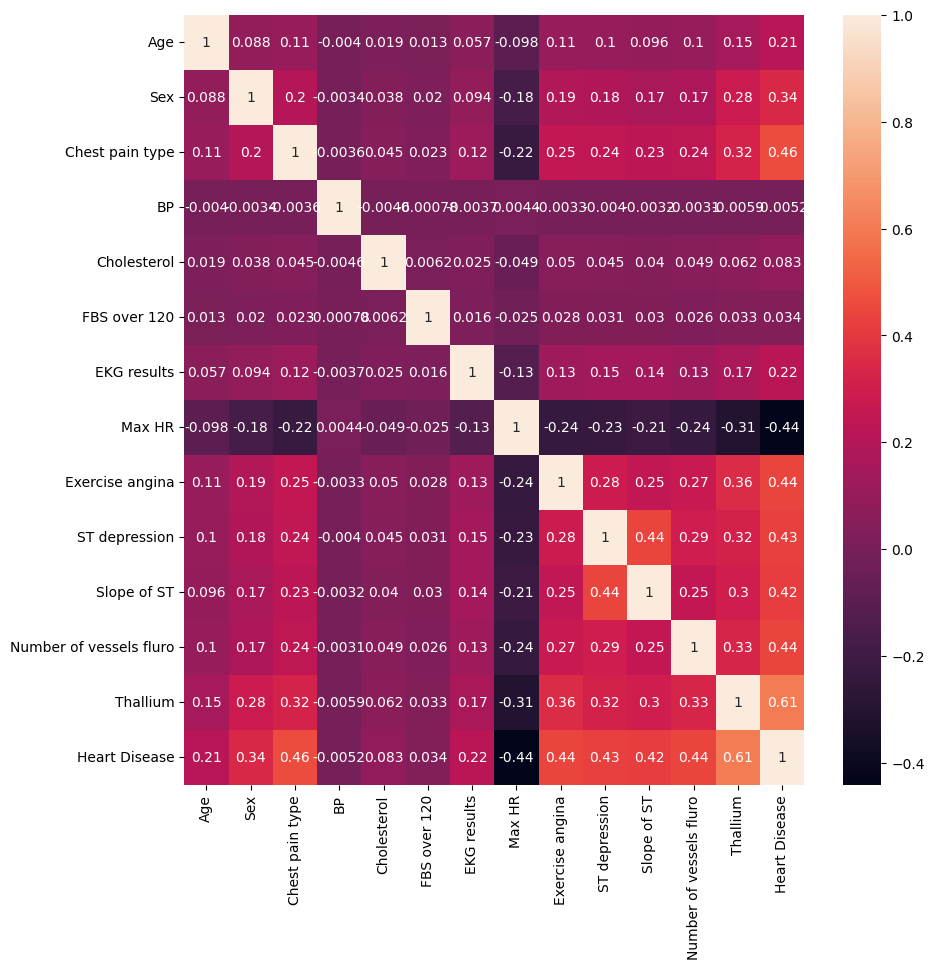

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_with_num_label.corr(), annot=True)

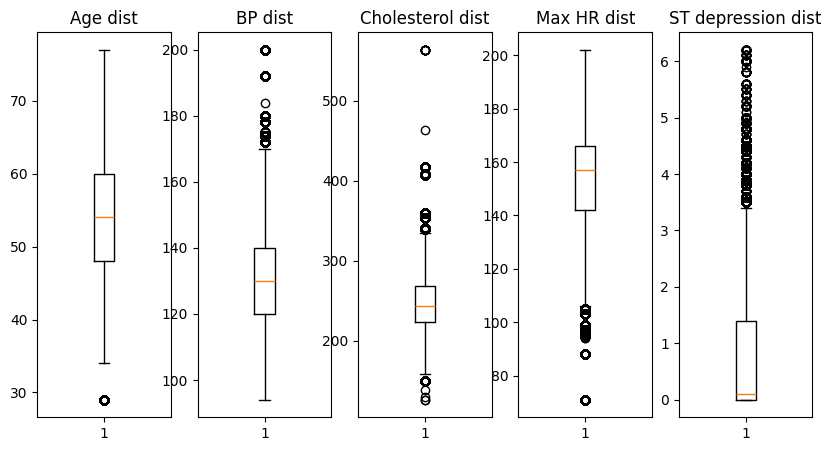

In [10]:
fig, ax = plt.subplots(1, len(NUM_COLUMNS), figsize=(10, 5))
for i in range(len(NUM_COLUMNS)):
    ax[i].boxplot(train_with_num_label[NUM_COLUMNS[i]])
    ax[i].set_title(NUM_COLUMNS[i] + " dist")

In [11]:
train["Cholesterol"] = np.clip(train["Cholesterol"], None, train["Cholesterol"].quantile(0.999))

# Model fitting 

In [12]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, output_sparse=True, dtype=float, unknown_value=0.0):
        self.output_sparse = output_sparse
        self.dtype = dtype
        self.unknown_value = unknown_value

    def fit(self, X, y=None):
        X = self._to_2d_object(X)
        self.n_features_in_ = X.shape[1]

        self._maps_ = []
        n = X.shape[0]
        for j in range(self.n_features_in_):
            cnt = Counter(X[:, j].tolist())
            self._maps_.append({k: (v / n) for k, v in cnt.items()})
        return self

    def transform(self, X):
        check_is_fitted(self, attributes=["_maps_", "n_features_in_"])
        X = self._to_2d_object(X)

        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features, got {X.shape[1]}")

        out = np.empty((X.shape[0], self.n_features_in_), dtype=self.dtype)
        for j, mp in enumerate(self._maps_):
            out[:, j] = np.fromiter((mp.get(v, self.unknown_value) for v in X[:, j]), dtype=self.dtype)

        return sparse.csr_matrix(out) if self.output_sparse else out

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = [f"x{i}" for i in range(getattr(self, "n_features_in_", 0))]
        return np.asarray([f"freq__{f}" for f in input_features], dtype=object)

    @staticmethod
    def _to_2d_object(X):
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        X = np.asarray(X, dtype=object)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return X


BIN_COLUMNS = [
    "Max HR",
    "Age",
    # "ST depression"
]
NUM_CONT_COLUMNS = NUM_COLUMNS

xgb_es_rounds = 156


num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
])

bin_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("bins", KBinsDiscretizer(
        n_bins=10,
        encode="onehot",
        strategy="quantile",
    )),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", FeatureUnion(transformer_list=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ("freq", FrequencyEncoder(output_sparse=True)),
    ])),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, NUM_CONT_COLUMNS),
        # ("num_bins", bin_pipe, BIN_COLUMNS),
        ("cat", cat_pipe, CAT_COLUMNS),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)


In [13]:
cb_params = dict(
    loss_function="Logloss",
    random_seed=42,
    allow_writing_files=False,
    verbose=False,

    iterations=3655,
    depth=4,
    learning_rate=0.033382081130147116,
    l2_leaf_reg=0.893029919896381,
    min_data_in_leaf=23,
    border_count=151,

    od_type="Iter",
    od_wait=231,

)
xgb_params = dict(
    base_score=None, booster=None, callbacks=[],
    colsample_bylevel=np.float64(0.9507904281995785),
    colsample_bynode=None, colsample_bytree=1.0, device=None,
    early_stopping_rounds=None, enable_categorical=False,
    eval_metric=None, feature_types=None, feature_weights=None,
    gamma=None, grow_policy=None, importance_type=None,
    interaction_constraints=None,
    learning_rate=np.float64(0.1393804049974062), max_bin=None,
    max_cat_threshold=None, max_cat_to_onehot=None,
    max_delta_step=None, max_depth=2, max_leaves=None,
    min_child_weight=np.float64(0.9933137882303046), missing=np.nan,
    monotone_constraints=None, multi_strategy=None, n_estimators=1699,
    n_jobs=-1, num_parallel_tree=None
)

lgb_params = {'n_estimators': 2398, 'num_leaves': 4, 'min_child_samples': 62, 'learning_rate': np.float64(0.08242393539659958), 'log_max_bin': 9, 'colsample_bytree': np.float64(0.35659474934153196), 'reg_alpha': np.float64(0.0012278801488545012), 'reg_lambda': np.float64(2.988747127151322)}
model_cb = Pipeline(steps=[
    # ("prep", cat_pipe),
    ("clf", CatBoostClassifier(
        **cb_params
    )),
])

model_xgb = Pipeline(steps=[
    # ("prep", preprocess),
    ("clf", XGBClassifier(
        **xgb_params
    )),
])

lgbm = Pipeline(steps=[
    # ("prep", preprocess),
    ("clf", LGBMClassifier(
        **lgb_params
    )),
])

ensemble = VotingClassifier(
    estimators=[
        ("cb", model_cb),
        ("xgb", model_xgb),
        ("lgbm", lgbm)
    ],
    voting="soft",
    n_jobs=1,
)

In [14]:
ensemble.fit(train.drop("Heart Disease", axis=1), train["Heart Disease"])

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Number of positive: 282454, number of negative: 347546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448340 -> initscore=-0.207381
[LightGBM] [Info] Start training from score -0.207381


VotingClassifier(estimators=[('cb',
                              Pipeline(steps=[('clf',
                                               <catboost.core.CatBoostClassifier object at 0x7a502bfbfbf0>)])),
                             ('xgb',
                              Pipeline(steps=[('clf',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=[],
                                                             colsample_bylevel=np.float64(0.9507904281995785),
                                                             colsample_bynode=None,
                                                             colsample_bytree=1.0,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categor...
                                                             num_parallel_tree=None, ...))])),
                             ('lgbm',
                              Pipeline(steps=[('clf',
                                               LGBMClassifier(colsample_bytree=np.float64(0.35659474934153196),
                                                              learning_rate=np.float64(0.08242393539659958),
                                                              log_max_bin=9,
                                                              min_child_samples=62,
                                                              n_estimators=2398,
                                                              num_leaves=4,
                                                              reg_alpha=np.float64(0.0012278801488545012),
                                                              reg_lambda=np.float64(2.988747127151322)))]))],
                 n_jobs=1, voting='soft')

In [15]:
# =========================
# FULL WORKING FRAGMENT (XGB early stopping compatible) + FIX cb_rsm KeyError
# =========================

import gc
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from catboost import CatBoostClassifier, CatBoostError
from xgboost import XGBClassifier


SEED = 42
N_SPLITS = 5
TARGET_COL = "Heart Disease"   # <-- change if needed
USE_GPU = False                # <-- True if you want GPU


def to_binary_target(y: pd.Series) -> np.ndarray:
    if pd.api.types.is_bool_dtype(y):
        return y.astype(np.int32).to_numpy()
    if pd.api.types.is_numeric_dtype(y):
        yy = y.to_numpy()
        uniq = np.unique(yy[~pd.isna(yy)])
        if len(uniq) == 2 and set(uniq.tolist()) <= {0, 1}:
            return yy.astype(np.int32)
        return (yy == np.max(uniq)).astype(np.int32)
    s = y.astype(str).str.strip().str.lower()
    if set(s.unique()) <= {"yes", "no"}:
        return (s == "yes").astype(np.int32).to_numpy()
    if set(s.unique()) <= {"true", "false"}:
        return (s == "true").astype(np.int32).to_numpy()
    codes, uniques = pd.factorize(y, sort=True)
    if len(uniques) != 2:
        raise ValueError(f"Expected binary target, got {len(uniques)} classes: {list(uniques)}")
    return codes.astype(np.int32)


def build_cb(trial: optuna.Trial) -> CatBoostClassifier:
    params = dict(
        loss_function="Logloss",
        random_seed=SEED,
        allow_writing_files=False,
        verbose=False,

        iterations=trial.suggest_int("cb_iterations", 800, 4000),
        depth=trial.suggest_int("cb_depth", 4, 10),
        learning_rate=trial.suggest_float("cb_lr", 1e-2, 0.2, log=True),
        l2_leaf_reg=trial.suggest_float("cb_l2", 1e-2, 20.0, log=True),

        min_data_in_leaf=trial.suggest_int("cb_min_data_in_leaf", 1, 128, log=True),
        border_count=trial.suggest_int("cb_border_count", 32, 255),

        od_type="Iter",
        od_wait=trial.suggest_int("cb_od_wait", 50, 400),
    )

    # IMPORTANT FIX:
    # keep cb_rsm ALWAYS in trial params (so best_params always has it),
    # but pass it to CatBoost ONLY on CPU (GPU may conflict with rsm).
    cb_rsm = trial.suggest_float("cb_rsm", 0.5, 1.0)

    if USE_GPU:
        params.update(dict(task_type="GPU", devices="0"))
        # do NOT pass rsm on GPU
    else:
        params.update(dict(task_type="CPU", thread_count=-1, rsm=cb_rsm))

    return CatBoostClassifier(**params)


def build_xgb(trial: optuna.Trial) -> XGBClassifier:
    params = dict(
        n_estimators=trial.suggest_int("xgb_n_estimators", 800, 6000),
        learning_rate=trial.suggest_float("xgb_lr", 5e-3, 0.2, log=True),
        max_depth=trial.suggest_int("xgb_max_depth", 3, 12),
        min_child_weight=trial.suggest_float("xgb_min_child_weight", 1e-2, 50.0, log=True),
        subsample=trial.suggest_float("xgb_subsample", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("xgb_colsample", 0.5, 1.0),
        reg_lambda=trial.suggest_float("xgb_reg_lambda", 1e-3, 50.0, log=True),
        reg_alpha=trial.suggest_float("xgb_reg_alpha", 1e-8, 10.0, log=True),
        gamma=trial.suggest_float("xgb_gamma", 0.0, 10.0),

        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1,
        tree_method="hist",
    )
    if USE_GPU:
        params.update(dict(device="cuda"))
    return XGBClassifier(**params)


def fit_xgb_with_es(model: XGBClassifier, Xtr, ytr, Xva, yva, rounds: int):
    """
    Compatible early stopping across xgboost versions:
      1) try early_stopping_rounds in fit
      2) fallback to callbacks=[xgb.callback.EarlyStopping(...)]
      3) fallback to plain fit without early stopping
    """
    try:
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            verbose=False,
            early_stopping_rounds=rounds,
        )
        return
    except TypeError:
        pass

    try:
        cb = [xgb.callback.EarlyStopping(rounds=rounds, save_best=True)]
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            verbose=False,
            callbacks=cb,
        )
        return
    except TypeError:
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            verbose=False,
        )


def xgb_predict_proba_best(model: XGBClassifier, X):
    """
    Try to use best_iteration if present (varies by xgboost version).
    """
    bi = None
    for attr in ("best_iteration", "best_iteration_"):
        if hasattr(model, attr):
            bi = getattr(model, attr)
            if bi is not None:
                break

    if bi is not None:
        bi = int(bi)
        # new API
        try:
            return model.predict_proba(X, iteration_range=(0, bi + 1))
        except TypeError:
            pass
        # older API
        try:
            return model.predict_proba(X, ntree_limit=bi + 1)
        except TypeError:
            pass

    return model.predict_proba(X)


def objective(trial: optuna.Trial, train: pd.DataFrame, preprocess):
    X = train.drop(TARGET_COL, axis=1)
    y = to_binary_target(train[TARGET_COL])

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    w_cb = trial.suggest_float("ens_w_cb", 0.1, 0.9)
    xgb_es = trial.suggest_int("xgb_es_rounds", 30, 300)

    scores = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # preprocess fit on train only
        prep = clone(preprocess)
        Xtr_t = prep.fit_transform(X_tr)
        Xva_t = prep.transform(X_va)

        # CatBoost
        cb = build_cb(trial)
        cb.fit(
            Xtr_t, y_tr,
            eval_set=(Xva_t, y_va),
            use_best_model=True,
        )
        p_cb = cb.predict_proba(Xva_t)[:, 1]

        # XGBoost (compat ES)
        xgbm = build_xgb(trial)
        fit_xgb_with_es(xgbm, Xtr_t, y_tr, Xva_t, y_va, rounds=xgb_es)
        p_xgb = xgb_predict_proba_best(xgbm, Xva_t)[:, 1]

        p = w_cb * p_cb + (1.0 - w_cb) * p_xgb
        auc = roc_auc_score(y_va, p)
        scores.append(auc)

        trial.report(float(np.mean(scores)), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

        del prep, Xtr_t, Xva_t, cb, xgbm, p_cb, p_xgb, p
        gc.collect()

    return float(np.mean(scores))


def run_optuna(train: pd.DataFrame, preprocess, n_trials: int = 50):
    sampler = optuna.samplers.TPESampler(seed=SEED)
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
    study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

    study.optimize(
        lambda t: objective(t, train, preprocess),
        n_trials=n_trials,
        gc_after_trial=True,
        catch=(CatBoostError, ValueError),
    )

    print("Best AUC:", study.best_value)
    print("Best params:", study.best_params)
    return study


def build_ensemble_from_best(best_params: dict, preprocess):
    # --- CatBoost ---
    cb_kwargs = dict(
        verbose=200,
        loss_function="Logloss",
        random_seed=SEED,
        allow_writing_files=False,

        iterations=int(best_params["cb_iterations"]),
        depth=int(best_params["cb_depth"]),
        learning_rate=float(best_params["cb_lr"]),
        l2_leaf_reg=float(best_params["cb_l2"]),
        min_data_in_leaf=int(best_params["cb_min_data_in_leaf"]),
        border_count=int(best_params["cb_border_count"]),
        od_type="Iter",
        od_wait=int(best_params["cb_od_wait"]),
    )

    if USE_GPU:
        cb_kwargs.update(dict(task_type="GPU", devices="0"))
        # rsm not passed on GPU
    else:
        cb_kwargs.update(dict(task_type="CPU", thread_count=-1))
        cb_kwargs["rsm"] = float(best_params.get("cb_rsm", 1.0))  # SAFE fallback

    cb = CatBoostClassifier(**cb_kwargs)

    model_cb = Pipeline(steps=[
        ("prep", clone(preprocess)),
        ("clf", cb),
    ])

    # --- XGBoost ---
    xgbm = XGBClassifier(
        n_estimators=int(best_params["xgb_n_estimators"]),
        learning_rate=float(best_params["xgb_lr"]),
        max_depth=int(best_params["xgb_max_depth"]),
        min_child_weight=float(best_params["xgb_min_child_weight"]),
        subsample=float(best_params["xgb_subsample"]),
        colsample_bytree=float(best_params["xgb_colsample"]),
        reg_lambda=float(best_params["xgb_reg_lambda"]),
        reg_alpha=float(best_params["xgb_reg_alpha"]),
        gamma=float(best_params["xgb_gamma"]),
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1,
        tree_method="hist",
        **({"device": "cuda"} if USE_GPU else {}),
    )

    model_xgb = Pipeline(steps=[
        ("prep", clone(preprocess)),
        ("clf", xgbm),
    ])

    w_cb = float(best_params["ens_w_cb"])

    ensemble = VotingClassifier(
        estimators=[("cb", model_cb), ("xgb", model_xgb)],
        voting="soft",
        weights=[w_cb, 1.0 - w_cb],
        n_jobs=1,
    )
    return ensemble


# =========================
# Usage
# =========================
# study = run_optuna(train, preprocess, n_trials=50)
# ensemble = build_ensemble_from_best(study.best_params, preprocess)

# If you already have best_params:
best_params = {
    'ens_w_cb': 0.8402766722774058,
    'xgb_es_rounds': 156,
    'cb_iterations': 3655,
    'cb_depth': 4,
    'cb_lr': 0.033382081130147116,
    'cb_l2': 0.893029919896381,
    'cb_min_data_in_leaf': 23,
    'cb_border_count': 151,
    'cb_od_wait': 231,
    # 'cb_rsm': 0.9,  # optional; safe if missing
    'xgb_n_estimators': 3817,
    'xgb_lr': 0.10026984626576654,
    'xgb_max_depth': 6,
    'xgb_min_child_weight': 4.749437616484939,
    'xgb_subsample': 0.5485378859389886,
    'xgb_colsample': 0.8271587149072527,
    'xgb_reg_lambda': 4.939831905315371,
    'xgb_reg_alpha': 0.0004507365169724808,
    'xgb_gamma': 5.9043357702728105
}

# ensemble = build_ensemble_from_best(best_params, preprocess)
# ensemble.fit(train.drop(TARGET_COL, axis=1), train[TARGET_COL])


# Predictions 

In [16]:
test.drop("id", inplace=True, axis=1)

In [17]:
preds = ensemble.predict_proba(test)

[LightGBM] [Warning] Unknown parameter: log_max_bin


In [18]:
preds

array([[0.04918222, 0.95081778],
       [0.99217218, 0.00782783],
       [0.00955922, 0.99044078],
       ...,
       [0.95415552, 0.04584448],
       [0.8157111 , 0.1842889 ],
       [0.9754647 , 0.02453531]])

In [19]:
sample_submit["Heart Disease"] = preds[:, 1]

In [20]:
sample_submit.to_csv("submission.csv", index=False)